In [8]:
# !pip install ibats_common
import ffn  # NOQA
import numpy as np
import pandas as pd
from sklearn import ensemble, preprocessing, metrics
from ibats_common.backend.factor import get_factor
from sklearn.model_selection import train_test_split, cross_val_score


In [1]:
from datetime import datetime
from vnpy.trader.constant import Exchange, Interval
from vnpy.trader.database import database_manager
import matplotlib.pyplot as plt

def plot_bar(symbol="RB2009", exchange=Exchange.SHFE, interval=Interval.MINUTE,
             start=datetime(2019, 4, 1), end=datetime(2020, 10, 30),
             label_count=15, fig_size=(16, 6), label_rotation=15, time_format='%Y-%m-%d %H:%M:%S'):
    # Load history data
    bars = database_manager.load_bar_data(
        symbol=symbol, exchange=exchange,
        interval=interval, start=start, end=end)

    # Generate x, y
    x = [bar.datetime for bar in bars]
    y = [bar.close_price for bar in bars]

    # Show plot
    y_len = len(y)
    xticks = list(range(0, y_len, y_len // label_count))
    xlabels = [x[_].strftime(time_format) for _ in xticks]
    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=label_rotation)
    plt.plot(y)
    plt.title(f"{symbol} {interval.value} {min(x).strftime(time_format)}~{max(x).strftime(time_format)}")
    plt.legend([symbol])
    plt.show()

d:\ide\vnstudio203\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


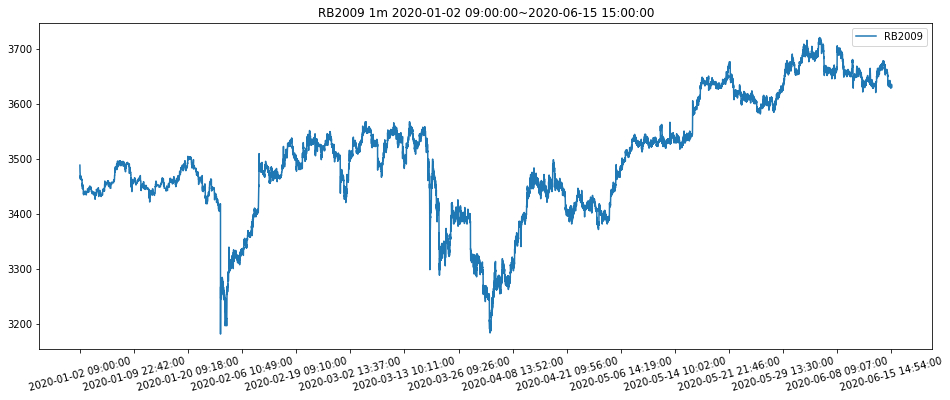

In [21]:
plot_bar(symbol="RB2009")

In [26]:
from ibats_common.backend.factor import get_factor

BAR_ATTRIBUTES = [
    'open_price', 'high_price', 'low_price', 'close_price',
    'datetime', 'volume',
]

def generate_factors(hist_bar_list):
    """整理缓存数据，生成相应的因子"""
    df = pd.DataFrame(
        [{key: getattr(_, key) for key in BAR_ATTRIBUTES}
         for _ in hist_bar_list]).set_index('datetime')
    df.index = pd.to_datetime(df.index)

    # 生成因子
    factor_df = get_factor(
        df,
        ohlcav_col_name_list=['open_price', 'high_price', 'low_price', 'close_price', None, 'volume'])
    return df, factor_df


获取数据

In [27]:
symbol="RB2009"
exchange=Exchange.SHFE
interval=Interval.MINUTE
start=datetime(2019, 4, 1)
end=datetime(2020, 10, 30)
bars = database_manager.load_bar_data(
    symbol=symbol, exchange=exchange,
    interval=interval, start=start, end=end)


In [33]:
bars[0], bars[0].datetime, bars[-1].datetime

(BarData(gateway_name='DB', symbol='RB2009', exchange=<Exchange.SHFE: 'SHFE'>, datetime=datetime.datetime(2020, 1, 2, 9, 0), interval=<Interval.MINUTE: '1m'>, volume=3.0, open_price=3488.0, high_price=3488.0, low_price=3488.0, close_price=3488.0),
 datetime.datetime(2020, 1, 2, 9, 0),
 datetime.datetime(2020, 6, 15, 15, 0))

构建因子矩阵

In [29]:
hist_bar_df, factor_df = generate_factors(bars)
factor_df.shape

(28928, 111)

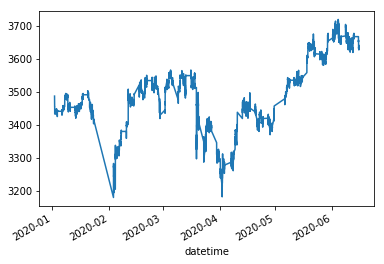

In [46]:
hist_bar_df['close_price'].plot()

构建y数据

In [30]:
y_s = hist_bar_df['close_price'].rolling(
    window=5).apply(lambda x: x.calc_calmar_ratio())

In [47]:
np.sum(y_s<=0), np.sum(y_s>0)

(13387, 11565)

数据整理，剔除无效数据

In [54]:
# 剔除无效数据
is_available = ~(np.isinf(y_s) | np.isnan(y_s) | np.any(np.isnan(factor_df), axis=1))
x_arr = hist_bar_df[is_available].to_numpy()
y_arr = y_s[is_available]
# 生成 -1 1 分类结果
y_arr[y_arr > 0] = 1
y_arr[y_arr <= 0] = -1
x_train_arr, x_test_arr, y_train_arr, y_test_arr = train_test_split(
    x_arr, y_arr, test_size=0.3)

In [56]:
y_s.shape, np.sum(np.isinf(y_s)), np.sum(np.isnan(y_s)), np.sum(np.any(np.isnan(factor_df), axis=1))
np.sum(y_arr==-1), np.sum(y_arr==1)

(13387, 6340)

创建分类器

In [38]:
# Train classifier
# 弱学习器的最大迭代次数，
# n_estimators太小，容易欠拟合，n_estimators太大，又容易过拟合，
# 一般选择一个适中的数值。默认是50。
# 在实际调参的过程中，我们常常将n_estimators和learning_rate一起考虑。
n_estimators = 150
# 对于同样的训练集拟合效果，
# 较小的ν意味着我们需要更多的弱学习器的迭代次数。
# 通常用步长和迭代最大次数一起来决定算法的拟合效果。
# 所以这两个参数n_estimators和learning_rate要一起调参。
# 一般来说，可以从一个小一点的ν开始调参，默认是1。
learning_rate = 1.0
scaler = preprocessing.MinMaxScaler()
clf = ensemble.AdaBoostClassifier(
    n_estimators=n_estimators, learning_rate=learning_rate)

开始训练

In [59]:
x_train_trans_arr = scaler.fit_transform(x_train_arr)
# print 'type(X_train_trans),X_train_trans[:5,:]\n%s\n%s'%(type(X_train_trans),X_train_trans[:5,:])
# print 'type(Y_train),Y_train.head()\n%s\n%s'%(type(Y_train),Y_train.head())
clf.fit(x_train_trans_arr, y_train_arr)
# 交叉检验
y_pred = clf.predict(x_train_trans_arr)
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(y_train_arr, y_pred) * 100))
x_test_trans = scaler.transform(x_test_arr)
y_pred = clf.predict(x_test_trans)
y_pred_prob = clf.predict_proba(x_test_trans)
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(y_test_arr, y_pred) * 100))
print('Log-loss on test set = {:.5f}'.format(metrics.log_loss(y_test_arr, y_pred_prob) * 100))


Accuracy on train set = 67.89%
Accuracy on test set = 68.39%
Log-loss on test set = 69.18985


开始交叉验证训练

In [66]:
import itertools

scaler = preprocessing.MinMaxScaler()
x_trans_arr = scaler.fit_transform(x_arr)
for n, rate in itertools.product(range(50, 301, 50), [0.5, 0.1, 0.01]):
    estimator = ensemble.AdaBoostClassifier(
    n_estimators=n, learning_rate=rate)
    result = np.array(cross_val_score(estimator, x_trans_arr, y_arr)) * 100
    print(f'n={n:3d} rate={rate:.2f} mean_res={np.mean(result):.2f}, std_res={np.std(result):.5f}, result={result}')

n= 50 rate=0.50 mean_res=66.13, std_res=3.16177, result=[67.46071972 67.51140395 59.8225602  67.85804816 68.01013942]
n= 50 rate=0.10 mean_res=67.86, std_res=0.00399, result=[67.86619361 67.86619361 67.85804816 67.85804816 67.85804816]
n= 50 rate=0.01 mean_res=67.86, std_res=0.00399, result=[67.86619361 67.86619361 67.85804816 67.85804816 67.85804816]
n=100 rate=0.50 mean_res=65.87, std_res=3.61853, result=[67.18195641 67.58743031 58.65652725 67.83269962 68.08618504]
n=100 rate=0.10 mean_res=67.86, std_res=0.00399, result=[67.86619361 67.86619361 67.85804816 67.85804816 67.85804816]
n=100 rate=0.01 mean_res=67.86, std_res=0.00399, result=[67.86619361 67.86619361 67.85804816 67.85804816 67.85804816]
n=150 rate=0.50 mean_res=65.76, std_res=3.64601, result=[67.18195641 67.20729853 58.50443599 67.83269962 68.08618504]
n=150 rate=0.10 mean_res=67.28, std_res=1.10460, result=[67.81550938 67.79016726 65.06970849 67.85804816 67.85804816]
n=150 rate=0.01 mean_res=67.86, std_res=0.00399, result=